In [39]:
import numpy as np

import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable 

import torch.nn as nn
import torch.nn.functional as F
import torch

In [40]:
channels = 1
img_size = 28
img_shape = (channels, img_size, img_size)

In [41]:
latent_dim = 100

In [42]:
cuda = True if torch.cuda.is_available() else False

In [43]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        img = img.view(img.size(0), *img_shape)
        return img

In [44]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )
        
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

In [45]:
adversarial_loss = torch.nn.BCELoss()

In [46]:
generator = Generator()
discriminator = Discriminator()

In [47]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [48]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [49]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [50]:
import pandas as pd
from torch.utils.data import Dataset

In [51]:
class DatasetMNIST(Dataset): # inherit abstract class - 'Dataset'
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image ad ndarray type (H, W, C)
        # be carefull for converting dtype to np.uint8 (Unsigned integer (0 to 255))
        # in this example, We use ToTensor(), so we define the numpy array like (H, W, C)
        
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28,28,1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [52]:
train = pd.read_csv('train.csv')

In [53]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
dataset = DatasetMNIST(file_path='train.csv', 
                       transform=transforms.Compose(
                           [transforms.ToTensor(), # ToTensor() : np.array (H, W, C) -> tensor (C, H, W)
                            transforms.Normalize([0.5],[0.5])]
                       ))

In [55]:
temp_img, _ =  dataset.__getitem__(0)

In [56]:
# temp_img

In [57]:
batch_size = 64 # suggested default, size of the batches
dataloader = DataLoader( # torch.utils.data.DataLoader
    dataset,
    batch_size=batch_size,
    shuffle=True
)

In [58]:
temp_images, _ = next(iter(dataloader)) # We don't use label, so _
print('images shape on batch size = {}'.format(temp_images.size()))

images shape on batch size = torch.Size([64, 1, 28, 28])


In [59]:
b1 = 0.5
b2 = 0.999
lr = 0.0002 

In [60]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [61]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [62]:
from tqdm.notebook import tqdm

In [63]:
import matplotlib.pyplot as plt

  0%|          | 0/657 [00:00<?, ?it/s]

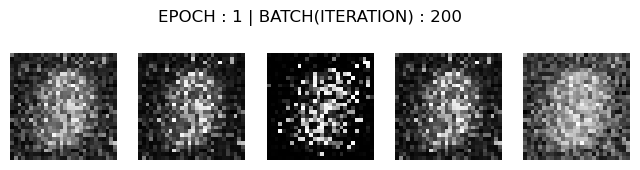

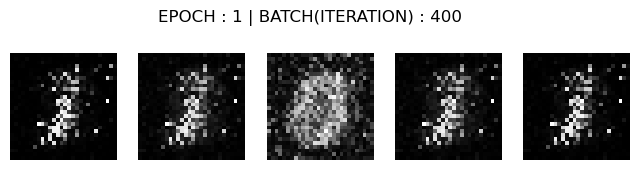

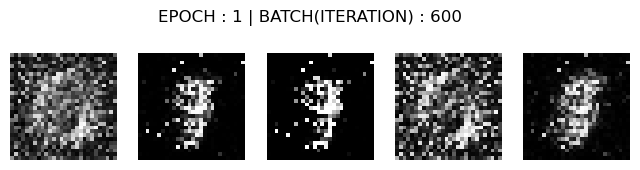

[Epoch: 1/10] [Batch: 657/657] [D loss: 0.695104] [G loss: 0.398977]


  0%|          | 0/657 [00:00<?, ?it/s]

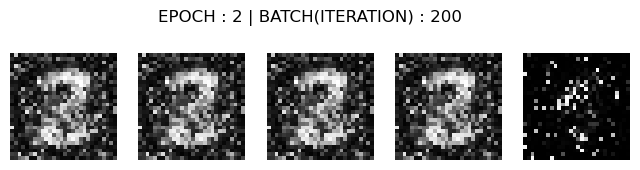

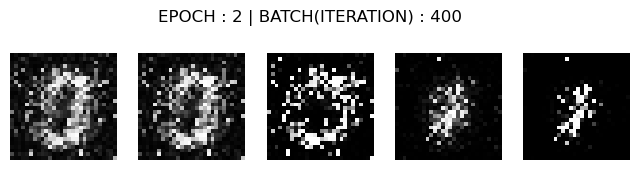

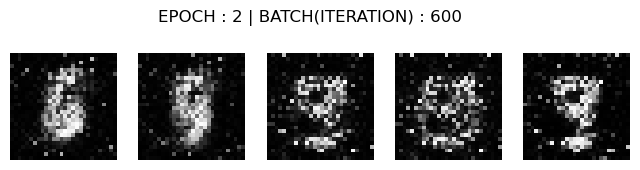

[Epoch: 2/10] [Batch: 657/657] [D loss: 0.447190] [G loss: 0.951483]


  0%|          | 0/657 [00:00<?, ?it/s]

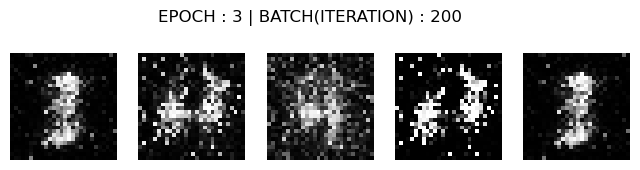

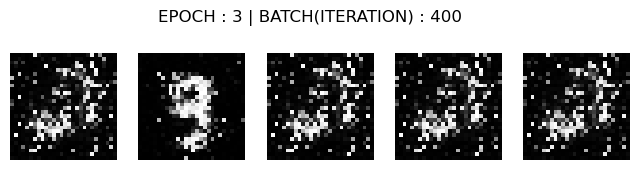

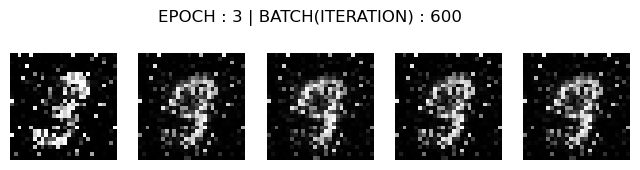

[Epoch: 3/10] [Batch: 657/657] [D loss: 0.273059] [G loss: 1.283299]


  0%|          | 0/657 [00:00<?, ?it/s]

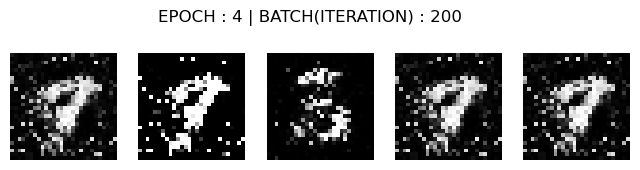

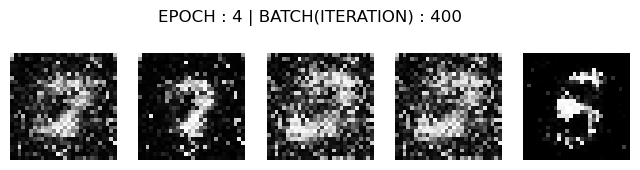

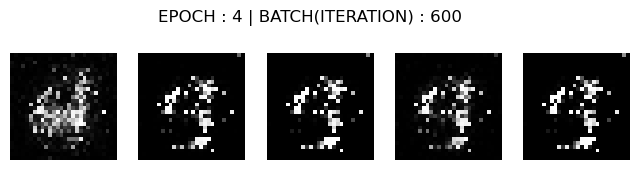

[Epoch: 4/10] [Batch: 657/657] [D loss: 0.461516] [G loss: 1.836945]


  0%|          | 0/657 [00:00<?, ?it/s]

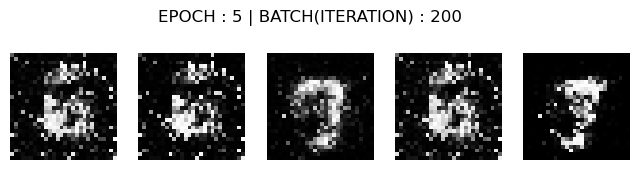

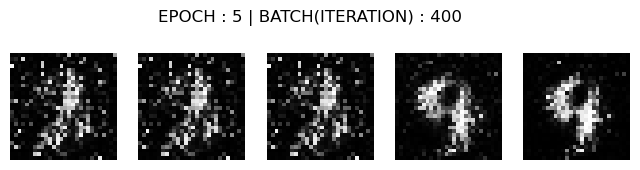

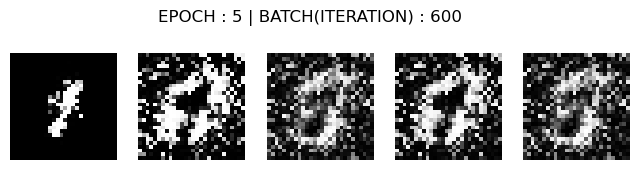

[Epoch: 5/10] [Batch: 657/657] [D loss: 0.390952] [G loss: 3.707231]


  0%|          | 0/657 [00:00<?, ?it/s]

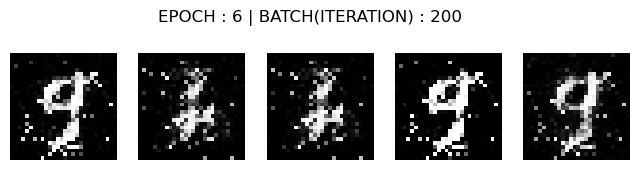

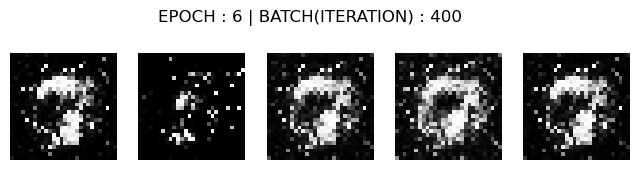

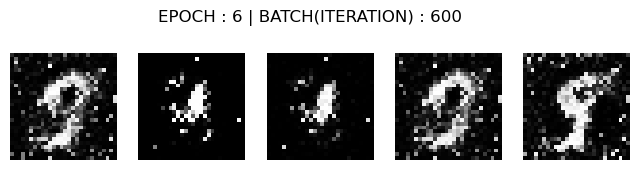

[Epoch: 6/10] [Batch: 657/657] [D loss: 1.003291] [G loss: 3.405458]


  0%|          | 0/657 [00:00<?, ?it/s]

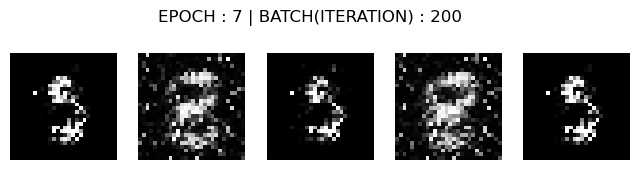

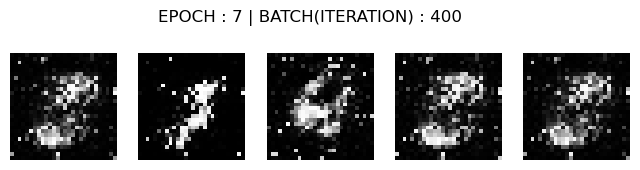

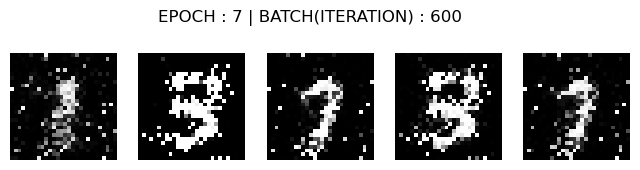

[Epoch: 7/10] [Batch: 657/657] [D loss: 0.144818] [G loss: 1.903135]


  0%|          | 0/657 [00:00<?, ?it/s]

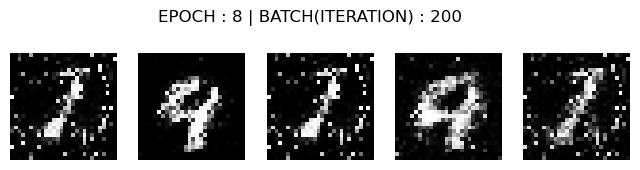

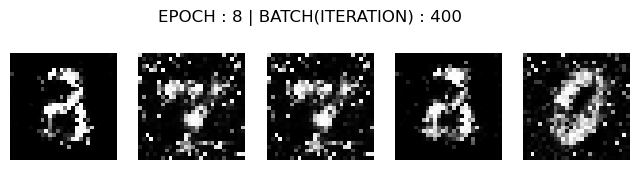

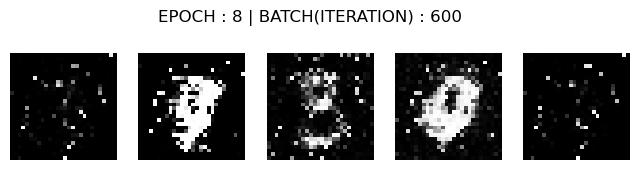

[Epoch: 8/10] [Batch: 657/657] [D loss: 0.190341] [G loss: 1.586563]


  0%|          | 0/657 [00:00<?, ?it/s]

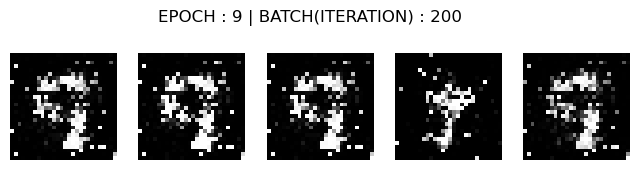

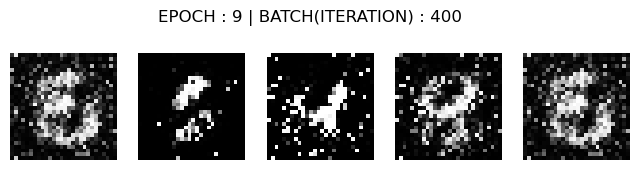

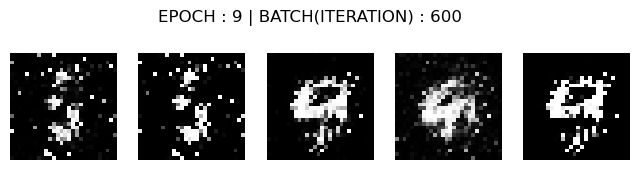

[Epoch: 9/10] [Batch: 657/657] [D loss: 0.264602] [G loss: 2.512549]


  0%|          | 0/657 [00:00<?, ?it/s]

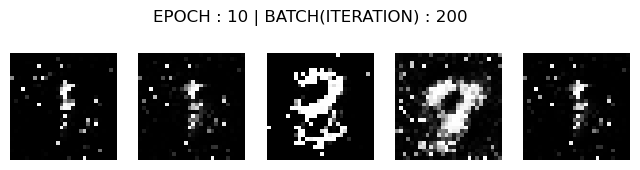

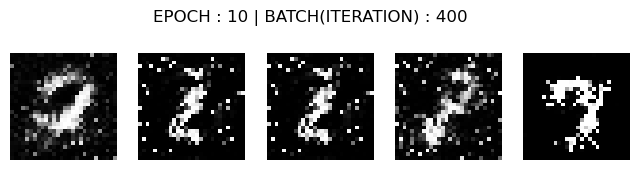

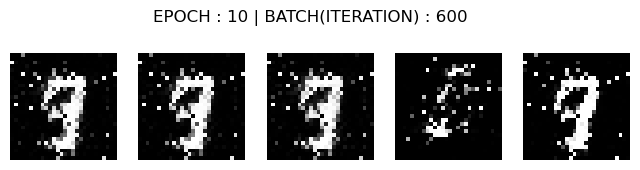

[Epoch: 10/10] [Batch: 657/657] [D loss: 0.262031] [G loss: 1.957658]


In [64]:
n_epochs = 10 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(dataloader)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress 
        
        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to. 
                                                                                # requires_grad=False is default in tensor type. *Read_More
        
        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.
    
# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()
        
        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])
        
        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        
        g_loss.backward()
        optimizer_G.step()
        
# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()
        
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach() 
                                                                             
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward(). 
        optimizer_D.step()
         
    

# ------------
# Real Time Visualization (While Training)
# ------------
        
        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])
        
        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(dataloader), d_loss.item(), g_loss.item())
    )

In [67]:
from typing import List, Tuple

def create_binary_list_from_int(number: int) -> List[int]:
    if number < 0 or type(number) is not int:
        raise ValueError("Only Positive integers are allowed")

    return [int(x) for x in list(bin(number))[2:]]

In [68]:
def generate_even_data(max_int: int, batch_size: int=16) -> Tuple[List[int], List[List[int]]]:
    # Get the number of binary places needed to represent the maximum number
    max_length = int(math.log(max_int, 2))

    # Sample batch_size number of integers in range 0-max_int
    sampled_integers = np.random.randint(0, int(max_int / 2), batch_size)

    # create a list of labels all ones because all numbers are even
    labels = [1] * batch_size

    # Generate a list of binary numbers for training.
    data = [create_binary_list_from_int(int(x * 2)) for x in sampled_integers]
    data = [([0] * (max_length - len(x))) + x for x in data]

    return labels, data

In [69]:
class Generator(nn.Module):

    def __init__(self, input_length: int):
        super(Generator, self).__init__()
        self.dense_layer = nn.Linear(int(input_length), int(input_length))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense_layer(x))

In [70]:
class Discriminator(nn.Module):
    def __init__(self, input_length: int):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(input_length), 1);
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.dense(x))

In [71]:
import math

import torch
import torch.nn as nn


def train(max_int: int = 128, batch_size: int = 16, training_steps: int = 500):
    input_length = int(math.log(max_int, 2))

    # Models
    generator = Generator(input_length)
    discriminator = Discriminator(input_length)

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()

    for i in range(training_steps):
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)

        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        generator_discriminator_out = discriminator(generated_data)
        generator_loss = loss(generator_discriminator_out, true_labels)
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)

        # add .detach() here think about this
        generator_discriminator_out = discriminator(generated_data.detach())
        generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros(batch_size))
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        discriminator_loss.backward()
        discriminator_optimizer.step()